# **Create Figures**
*This is a script for creating various figures for visualization of data and results*

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
from scipy.ndimage import binary_erosion
import pandas as pd


### **Visualize DWI images**


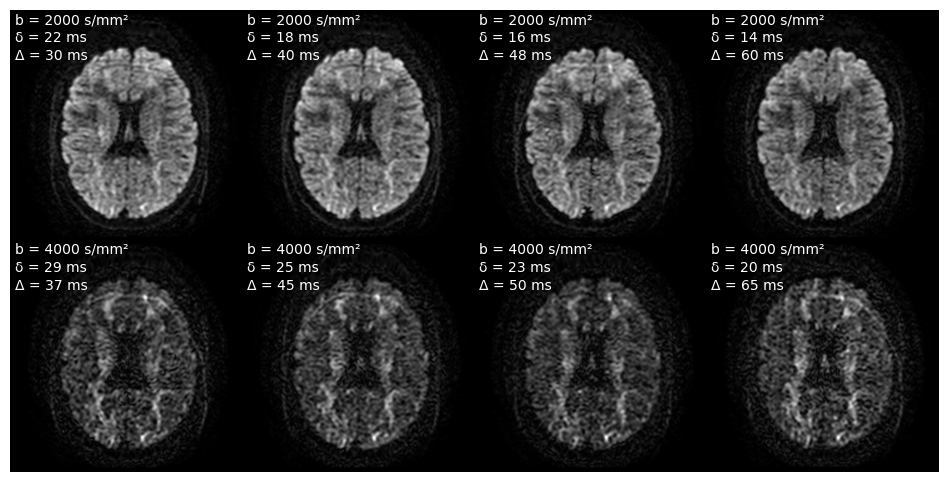

In [ ]:
ID = '' # Selct ID to view

# load dwi data (not normalized to view)
image_path = 'pre_processing/0_merged_files/'+ID+'.nii.gz'
nifti_file = nib.load(image_path)
dwi_data_original = nifti_file.get_fdata()
dwi_data = np.rot90(dwi_data_original)

#load mask data
mask_path = 'pre_processing/5_segmentation/masks/'+ID+'.nii.gz'
mask_file = nib.load(mask_path)
mask_data_original = mask_file.get_fdata()
mask_data = np.rot90(mask_data_original)

# View images
slice_index = 32
volume_index = 2
first_volume_for_b_val = np.array([0, 32, 64, 96, 128, 190, 252, 314])
volume = first_volume_for_b_val + volume_index

fig, axes = plt.subplots(2, 4, figsize=(12,6))
axes = axes.flatten()

bvals = ['b = 2000 s/mm\u00b2', 'b = 2000 s/mm\u00b2', 'b = 2000 s/mm\u00b2', 'b = 2000 s/mm\u00b2',
         'b = 4000 s/mm\u00b2', 'b = 4000 s/mm\u00b2', 'b = 4000 s/mm\u00b2', 'b = 4000 s/mm\u00b2']
delta = ['\u03B4 = 22 ms', '\u03B4 = 18 ms', '\u03B4 = 16 ms', '\u03B4 = 14 ms',
         '\u03B4 = 29 ms', '\u03B4 = 25 ms', '\u03B4 = 23 ms', '\u03B4 = 20 ms']  
Delta = ['\u0394 = 30 ms', '\u0394 = 40 ms', '\u0394 = 48 ms', '\u0394 = 60 ms',
         '\u0394 = 37 ms', '\u0394 = 45 ms', '\u0394 = 50 ms', '\u0394 = 65 ms'] 

for i in range(8):
    axes[i].imshow(dwi_data[:, :, slice_index, volume[i] ] , cmap='gray')
    axes[i].axis('off') 
    axes[i].text(5,15, bvals[i], color='white') 
    axes[i].text(5,35, delta[i], color='white') 
    axes[i].text(5,55, Delta[i], color='white')  

plt.subplots_adjust(wspace=-0.01, hspace=-0.01)
fig.patch.set_visible(False)
#plt.savefig('Figures/diffusion_images.png')

plt.show()

### **Visualize segmentations**
*Visualization of the segmented subcortical structures on top of the b0 volume*

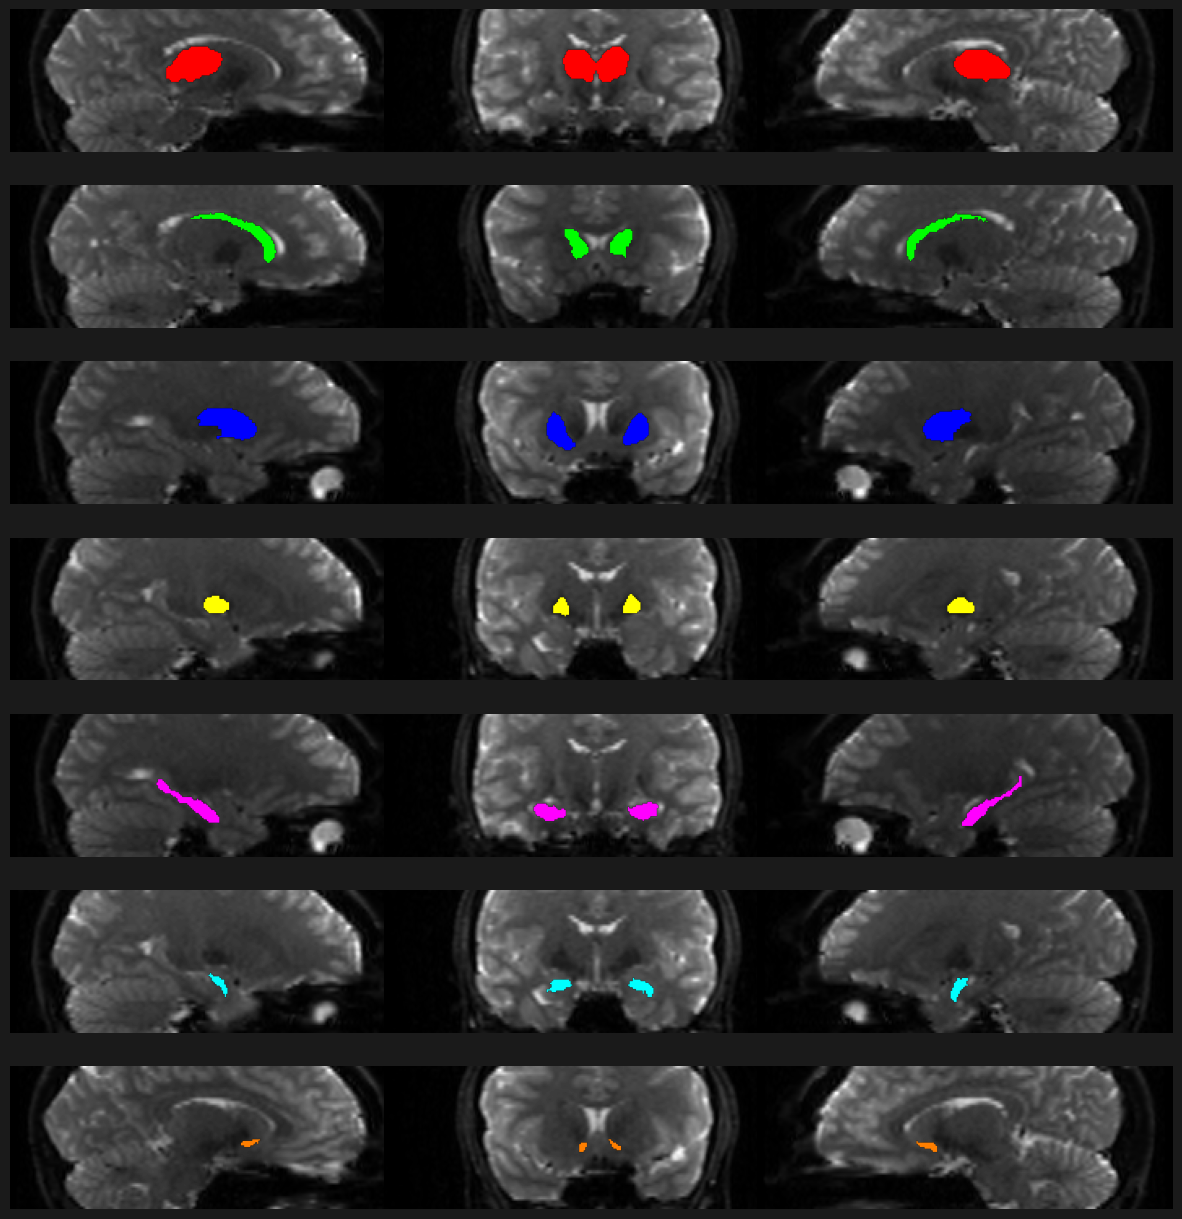

In [ ]:
ID = '' # Selct ID to view

# load dwi data (not normalized to view)
image_path = 'pre_processing/0_merged_files/'+ID+'.nii.gz'
nifti_file = nib.load(image_path)
dwi_data_original = nifti_file.get_fdata()
dwi_data = np.rot90(dwi_data_original)

#load mask data
mask_path = 'pre_processing/5_segmentation/masks/'+ID+'.nii.gz'
mask_file = nib.load(mask_path)
mask_data_original = mask_file.get_fdata()
mask_data = np.rot90(mask_data_original)

b0 = dwi_data[:, :, :, 0] 
zoom_factors = (1.0, 1.0, 2.0/1.0)
dwi_resampled = zoom(b0, zoom=zoom_factors, order=1)
mask_resampled = zoom(mask_data, zoom=zoom_factors, order=0)

def extract_single_mask(all_masks_file, mask_index):
     # mask_index is an array containing the values corresponding to the desired brain structure (left and right)
    mask = all_masks_file.copy()
    mask[(mask != mask_index[0]) & (mask != mask_index[1])]  = 0  #all values not the right label to 0
    mask = (mask != 0).astype(np.uint8) #make it binary
    mask = binary_erosion(mask, iterations=1).astype(mask.dtype) # perform erosion to get rid of edge values
    return mask

subcortical_structures_dict = {
    'Thalamus': [10, 49],
    'Caudate':[11, 50],
    'Putamen': [12, 51],
    'Pallidum': [13, 52],
    'Hippocampus': [17, 53],
    'Amygdala': [18, 54],
    'Accumbens Area': [26, 58]  } 

colors = [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0), (1.0, 1.0, 0.0),
          (1.0, 0.0, 1.0), (0.0, 1.0, 1.0), (1.0, 0.5, 0.0)] 

sideview_location_left =  [145, 149, 160, 155, 160, 156, 140]
sideview_location_right = [120, 113, 103, 108, 101, 108, 121] 
frontalview_location =    [136, 100, 110, 125, 135, 125, 108]  

#create figure
fig, axes = plt.subplots(7, 3, figsize=(15,17))

for idx, (structure, labels) in enumerate(subcortical_structures_dict.items()):
    mask = extract_single_mask(mask_resampled, labels)
    overlay_3d = np.zeros((*mask.shape, 4))
    for c in range(3):
        overlay_3d[:, :, :, c] =  mask *colors[idx][c]

    overlay_3d[..., 3] = mask 

    axes[idx, 0].imshow(np.fliplr(np.rot90(dwi_resampled[:, sideview_location_left[idx], :])), cmap='gray')
    axes[idx, 0].imshow(np.fliplr(np.rot90(overlay_3d[:, sideview_location_left[idx], :])))
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(np.rot90(dwi_resampled[frontalview_location[idx], :, :]) , cmap='gray')
    axes[idx, 1].imshow(np.rot90(overlay_3d[frontalview_location[idx], :, :]))
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(np.rot90(dwi_resampled[:, sideview_location_right[idx], :]) , cmap='gray')
    axes[idx, 2].imshow(np.rot90(overlay_3d[:, sideview_location_right[idx], :]))
    axes[idx, 2].axis('off')

plt.subplots_adjust(wspace=-0.10, hspace=-0.3)
fig.patch.set_facecolor((0.1, 0.1, 0.1))
plt.savefig('Figures/segmentation.png')
plt.show()


### **Visualize score distribution of questionnaires**

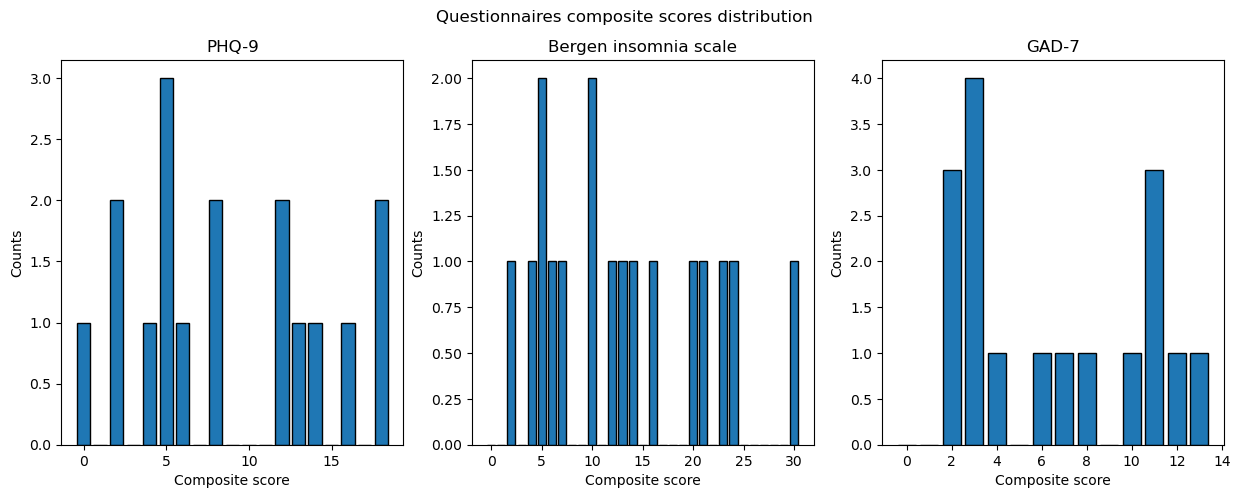

In [ ]:
df_PHQ = pd.read_excel('Patient data template.xlsx', sheet_name='PHQ-9', skiprows=[0,1,12], 
                       usecols=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] )
df_BIS = pd.read_excel('Patient data template.xlsx', sheet_name='BIS', skiprows=[0,11], 
                       usecols=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] )
df_GAD = pd.read_excel('Patient data template.xlsx', sheet_name='GAD-7', skiprows=[0,11], 
                       usecols=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] )

PHQ_scores = df_PHQ.sum(axis=1).to_numpy()
BIS_scores = df_BIS.sum(axis=1).to_numpy()
GAD_scores = df_GAD.sum(axis=1).to_numpy()

# temporary manual lists
PHQ_scores = np.array([13, 6, 16, 5, 2, 0, 18, 18, 5, 8, 8, 14, 12, 4, 2, 12, 5])
BIS_scores = np.array([21, 10, 23, 4, 5, 6, 20, 31, 12, 24, 14, 16, 5, 7, 2, 10, 13])
GAD_scores = np.array([8, 13, 11, 2, 3, 3, 11, 11, 3, 10, 2, 12, 6, 3, 4, 7, 2])


fig, axis = plt.subplots(1, 3, figsize=(15,5))
plt.suptitle('Questionnaires composite scores distribution')
axis[0].hist(PHQ_scores, rwidth=0.8, bins=range(0,20), edgecolor='black', align='left')
#axis[0].set_xticks(range(0,19)) 
axis[0].set_title('PHQ-9') 
axis[0].set_xlabel('Composite score') 
axis[0].set_ylabel('Counts')
axis[1].hist(BIS_scores, rwidth=0.8, bins=range(0,32), edgecolor='black', align='left')
#axis[1].set_xticks(range(0,32))
axis[1].set_title('Bergen insomnia scale') 
axis[1].set_xlabel('Composite score') 
axis[1].set_ylabel('Counts')
axis[2].hist(GAD_scores, rwidth=0.8, bins=range(0,15), edgecolor='black', align='left')
axis[2].set_title('GAD-7') 
axis[2].set_xlabel('Composite score') 
axis[2].set_ylabel('Counts')

plt.savefig('Figures/questionnaire_score_distribution.png')

### **MSE and R2 plots (model selection)**
*The code below imports the MSE and R2 values generated from running the "model_design_and_testing" script and merging the seperate dataframes using the "combine_dataframes" script. The script can be used to generate a figure containing results of only one participant or two for comparison.*

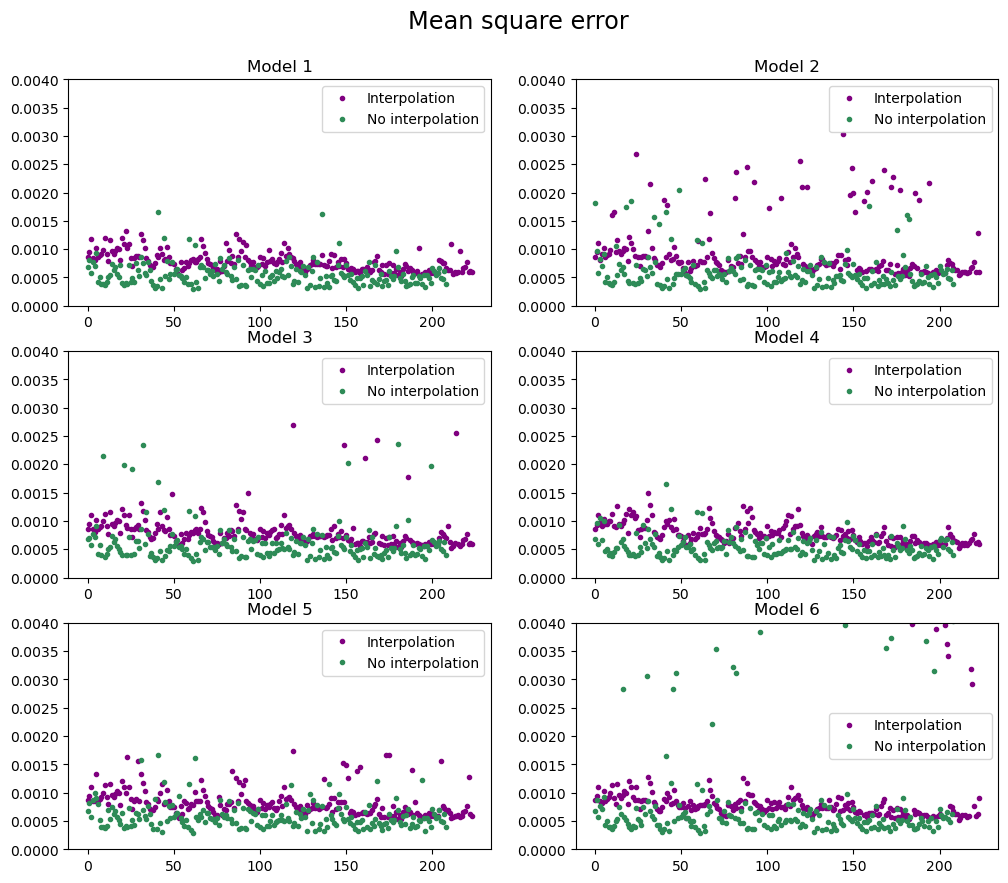

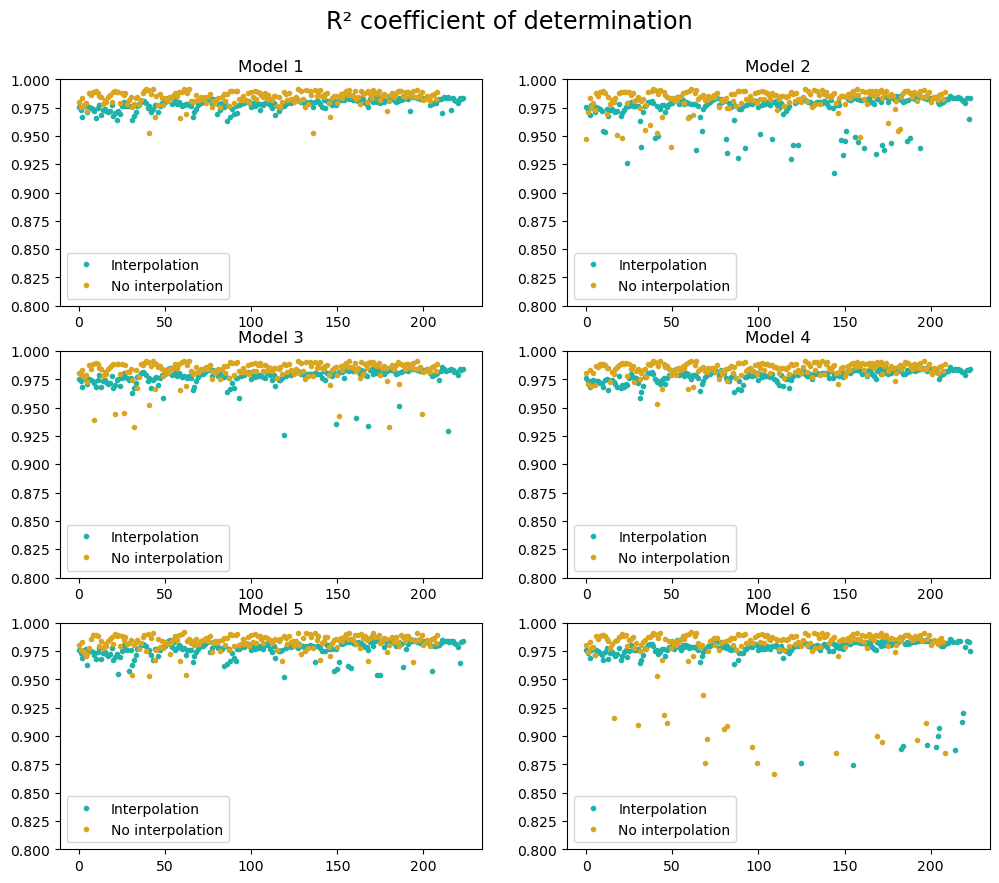

In [ ]:
ID = '' # select ID
MSE = pd.read_json('MSE_values.json', orient='index')
R2 = pd.read_json('R2_values.json', orient='index')
model_description = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'] 

fig, axes = plt.subplots(3, 2, figsize=(12,10))
axes = axes.flatten()

for i in range(len(model_description)):
    values = np.array(MSE.loc[ID, model_description[i]][0] )
    x = [i for i in range(len(values))]
    axes[i].plot(x, values, '.', color='purple', label='Interpolation')

    ID2 = '' # Add a second ID to plot dubble
    values = np.array(MSE.loc[ID2, model_description[i]][0] )    # Add this block of code to plot performance 
    x = [i for i in range(len(values))]                         # on seperate subjects on to of each other
    axes[i].plot(x, values, '.', color='seagreen', label='No interpolation')

    axes[i].set_ylim(0, 0.004) 
    axes[i].set_title(model_description[i] ) 
    axes[i].legend() 
fig.suptitle('Mean square error', fontsize='xx-large', y=0.95)
plt.savefig('Figures/mean_square_error_combined.png')   


fig, axes = plt.subplots(3, 2, figsize=(12,10))
axes = axes.flatten()

for i in range(len(model_description)):
    values = np.array(R2.loc[ID, model_description[i]][0] )
    x = [i for i in range(len(values))]
    axes[i].plot(x, values, '.', color='lightseagreen', label='Interpolation')

    ID2 = '' # Add a second ID to plot dubble
    values = np.array(R2.loc[ID2, model_description[i]][0] )    # Add this block of code to plot performance 
    x = [i for i in range(len(values))]                         # on seperate subjects on to of each other
    axes[i].plot(x, values, '.', color='goldenrod', label='No interpolation')

    axes[i].set_ylim(0.8, 1.0) 
    axes[i].set_title(model_description[i] ) 
    axes[i].legend()
fig.suptitle('R\u00b2 coefficient of determination', fontsize='xx-large', y=0.95) 
plt.savefig('Figures/coefficient_of_determination_combined.png')

### **Fitted parameter distribution (model evaluation)**
*The code below creates a figure containing histograms of all fitted parameters (except vector describing the direction of the stick compartment) within the thalamus (big structure many datapoints) for one subject. For the partial volumes of the stick and the zeppelin some extra math is apllied to calculate them from the known values of the partial volume of the bundle and the partial volume of the stick withing the bundle.*

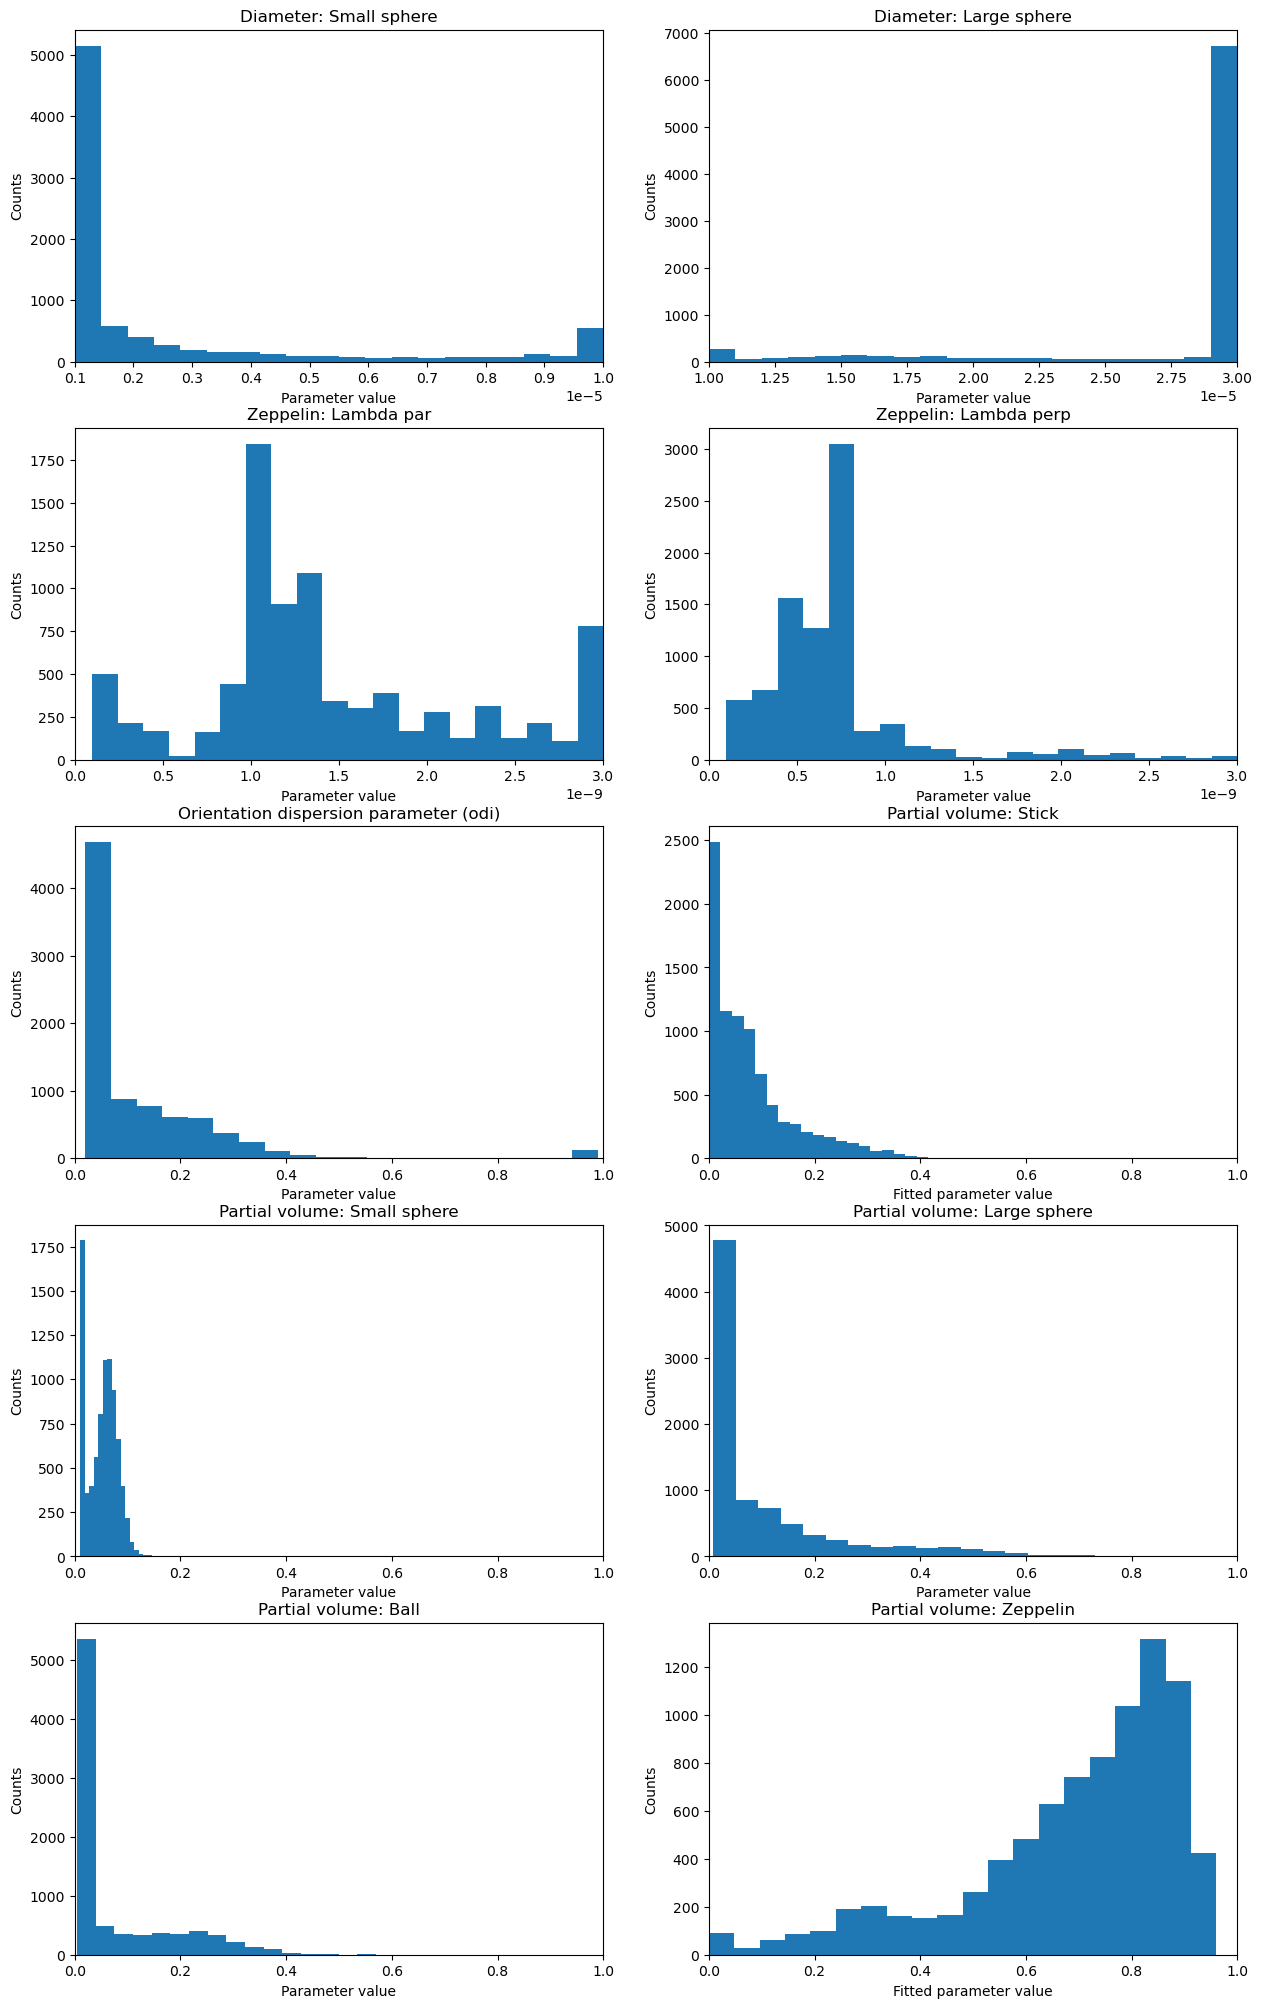

In [ ]:
ID = '' # Select ID

subcortical_structures_dict = {
    'Thalamus': [10, 49],
    'Caudate':[11, 50],
    'Putamen': [12, 51],
    'Pallidum': [13, 52],
    'Hippocampus': [17, 53],
    'Amygdala': [18, 54],
    'Accumbens Area': [26, 58]  }    

df = pd.read_json('Fitted_parameters_dataframes/Fitted_parameters_'+ID+'.json', orient='index')
isinstance(df.iloc[0,0], list)

fig, axes = plt.subplots(5, 2, figsize=(15,25))
axes = axes.flatten()

parameter_names = list(df.loc[ID, 'Thalamus'][0].keys())
parameter_names.remove('SD1WatsonDistributed_1_SD1Watson_1_mu')

plot_titles = ['Diameter: Small sphere', 'Diameter: Large sphere', 'Zeppelin: Lambda par', 'Zeppelin: Lambda perp', 
            'Orientation dispersion parameter (odi)', 'Partial volume: Stick',
            'Partial volume: Small sphere', 'Partial volume: Large sphere', 'Partial volume: Ball', 'Partial volume: Zeppelin'] 

xlims = [[1e-6, 1e-5], [1e-5, 3e-5], [0, 3e-9], [0, 3e-9], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]] 

for i in range(10):
    if i == 5: #from stick fraction within bundle and partial volume of bundle calculate partial volume of stick
        partial_volume_bundle = df.loc[ID, 'Thalamus'][0]['partial_volume_3'] 
        stick_fraction_in_bundle = df.loc[ID, 'Thalamus'][0]['SD1WatsonDistributed_1_partial_volume_0']
        partial_volume_stick = [b*s for b, s in zip(partial_volume_bundle, stick_fraction_in_bundle)] 
        axes[i].hist(partial_volume_stick, bins=20) 
        axes[i].set_title(plot_titles[i]) 
        axes[i].set_xlim(xlims[i]) 
        axes[i].set_xlabel('Fitted parameter value') 
        axes[i].set_ylabel('Counts') 
    elif i == 9: #from partial volume of bundle and partial volume of stick calculate partial volume of zeppelin
        partial_volume_bundle = df.loc[ID, 'Thalamus'][0]['partial_volume_3'] 
        stick_fraction_in_bundle = df.loc[ID, 'Thalamus'][0]['SD1WatsonDistributed_1_partial_volume_0']
        partial_volume_zeppelin = [b*(1-s) for b, s in zip(partial_volume_bundle, stick_fraction_in_bundle)] 
        axes[i].hist(partial_volume_zeppelin, bins=20) 
        axes[i].set_title(plot_titles[i]) 
        axes[i].set_xlim(xlims[i])  
        axes[i].set_xlabel('Fitted parameter value') 
        axes[i].set_ylabel('Counts')      
    else:
        axes[i].hist(df.loc[ID, 'Thalamus'][0][parameter_names[i]], bins=20)
        axes[i].set_title(plot_titles[i]) 
        axes[i].set_xlim(xlims[i])
        axes[i].set_xlabel('Parameter value') 
        axes[i].set_ylabel('Counts')

plt.savefig('Figures/Fitted_parameters_histogram/fitted_parameters_thalamus_histogram'+ID+'.png')



### **Visualize inter-subject variation**
*The inter-subject variation of the fitted parameters is below visualized by creating boxplots for four of the parameters; the small sphere diameter, the large sphere diameter, the stick dispersion parameter and the partial volume of the stick compartment. Based on earlier evaluation of the distribution of fitted parameters all parameters close to max/min is excluded before calculating the average. For the diameters this means all values close to max/min of range, and for the stick dispersion and volume fraction all values very close to either 0 or 1.*

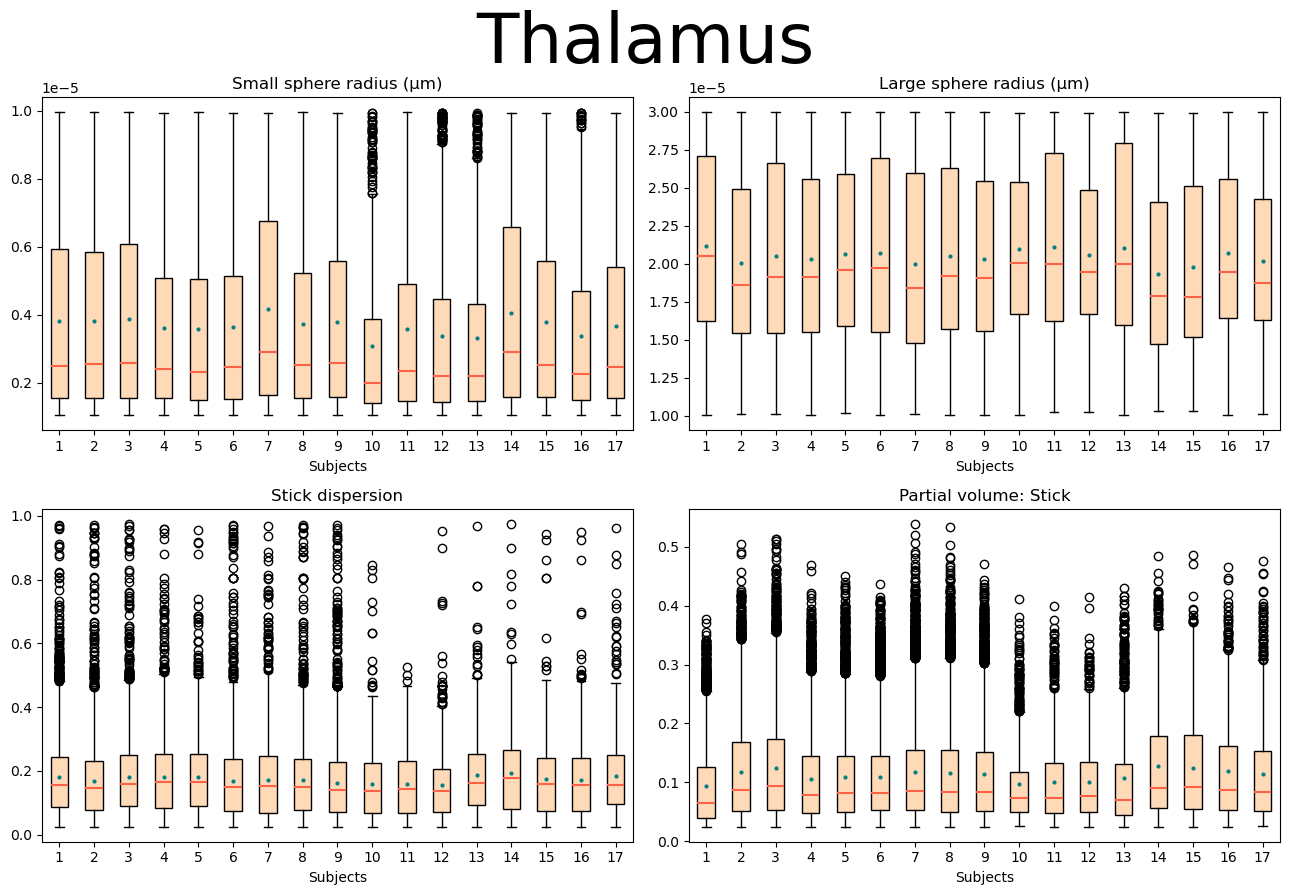

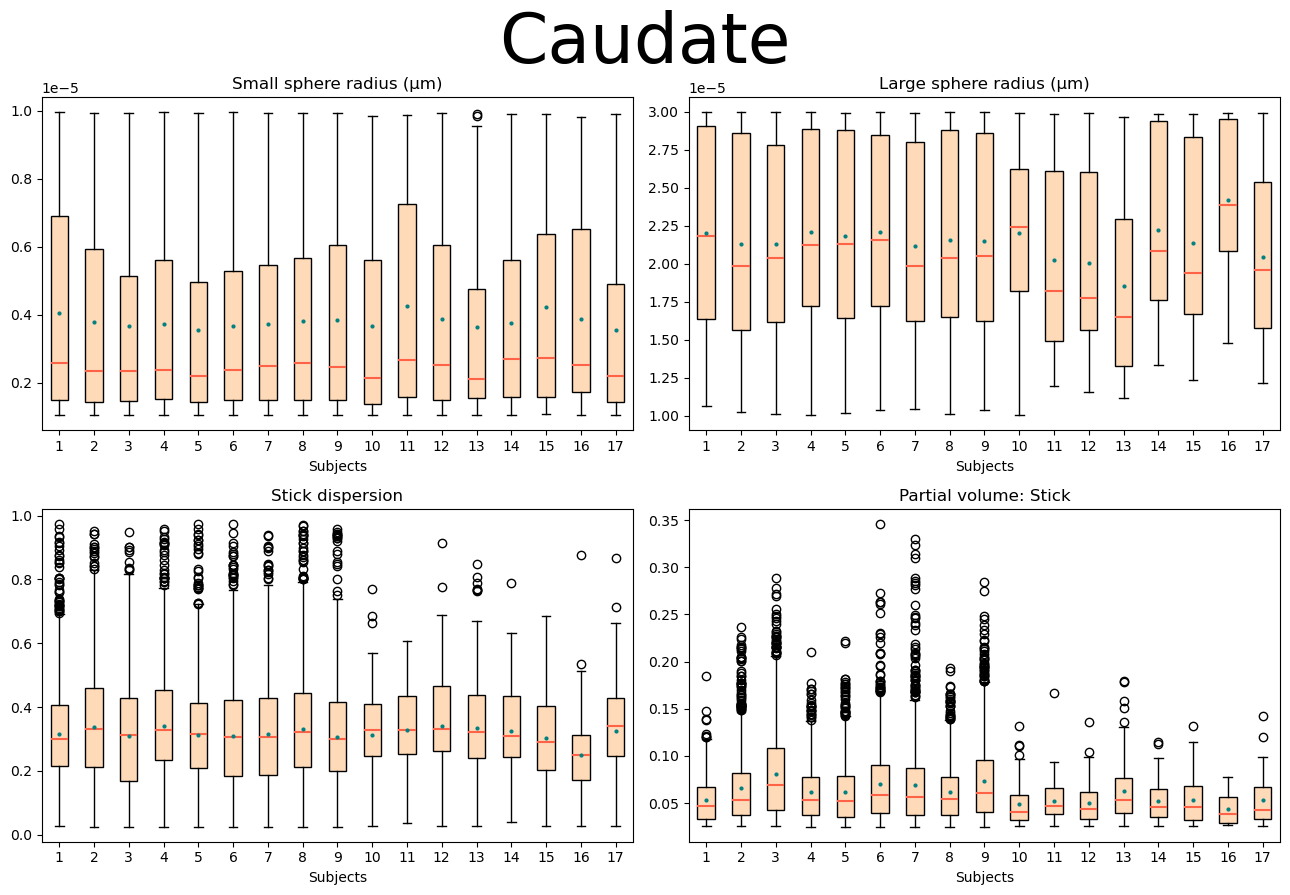

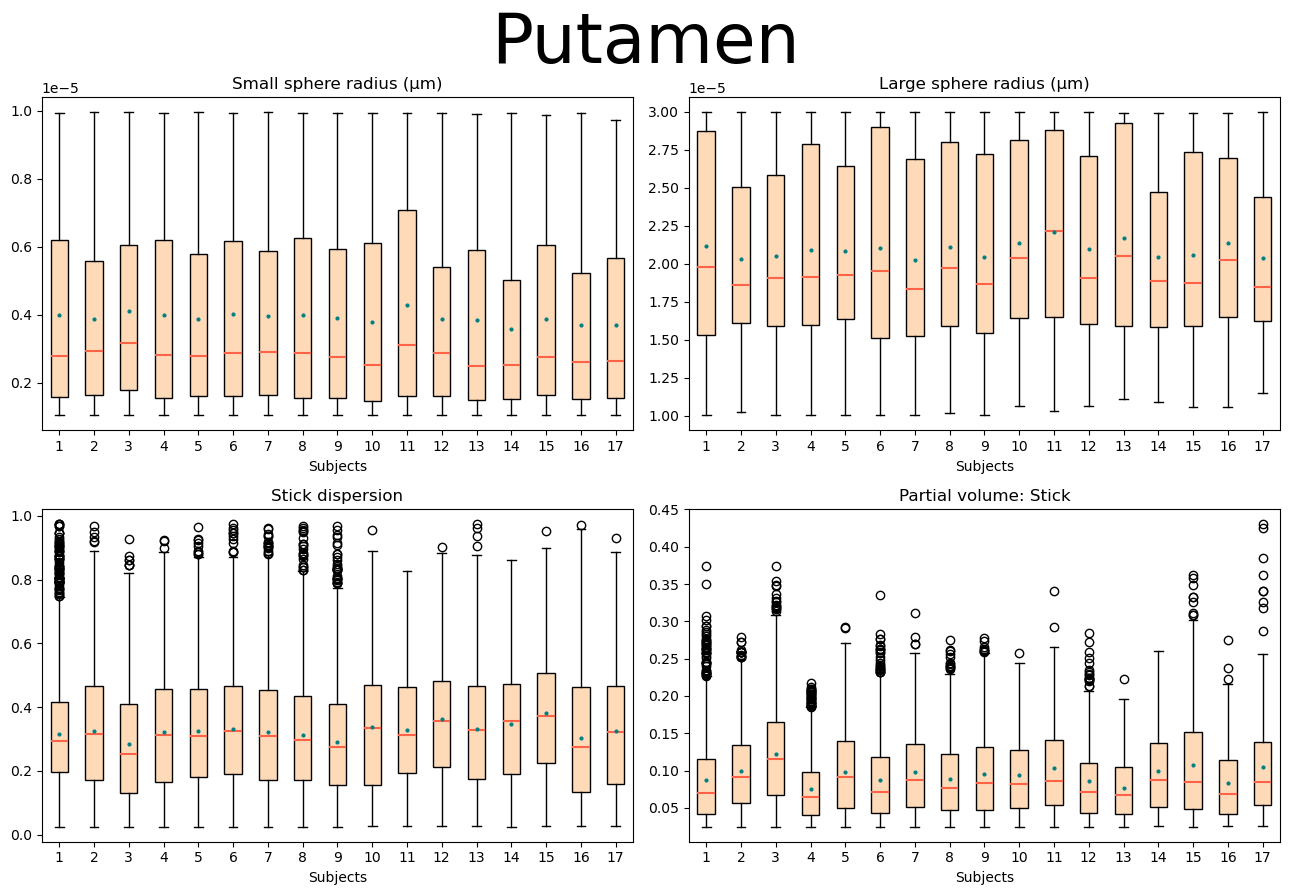

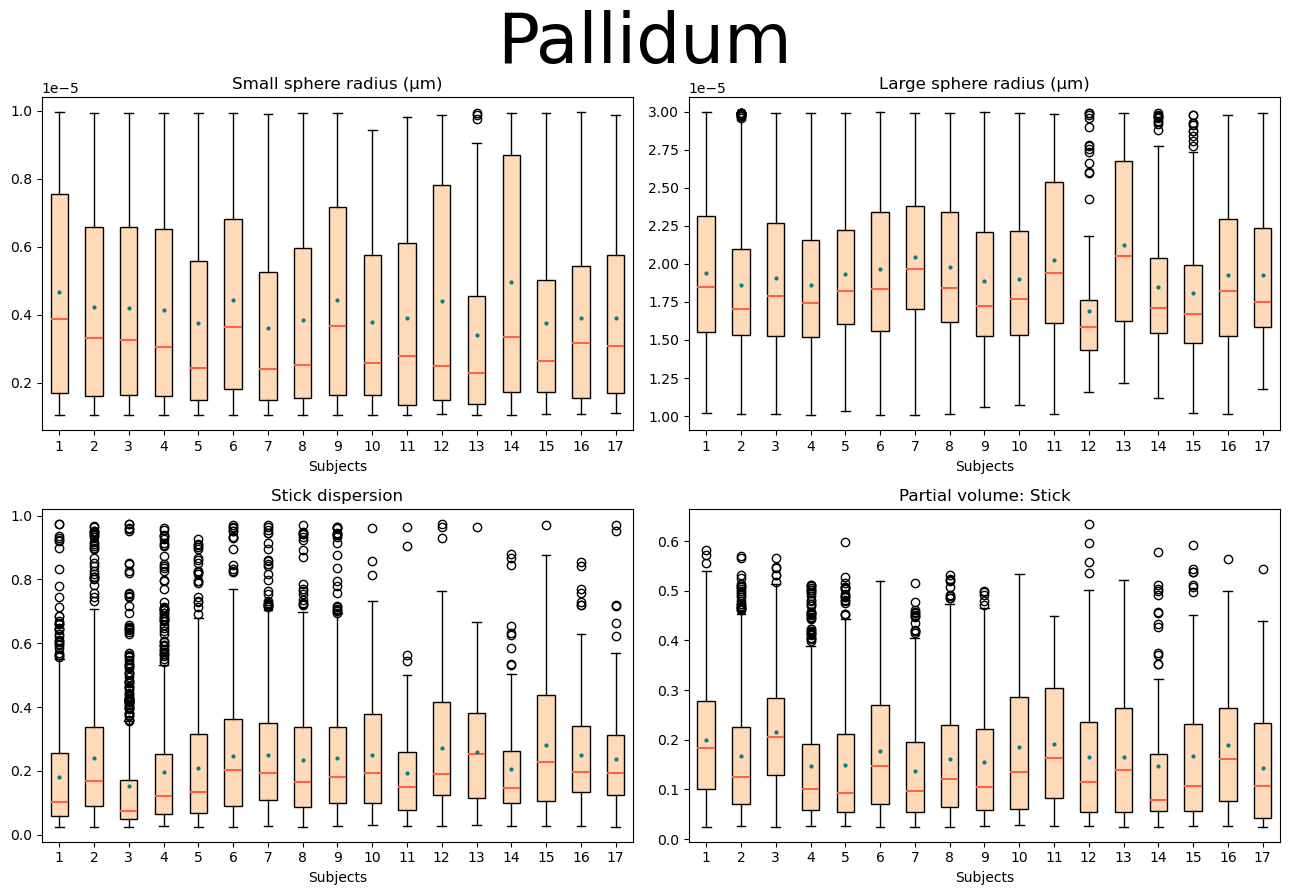

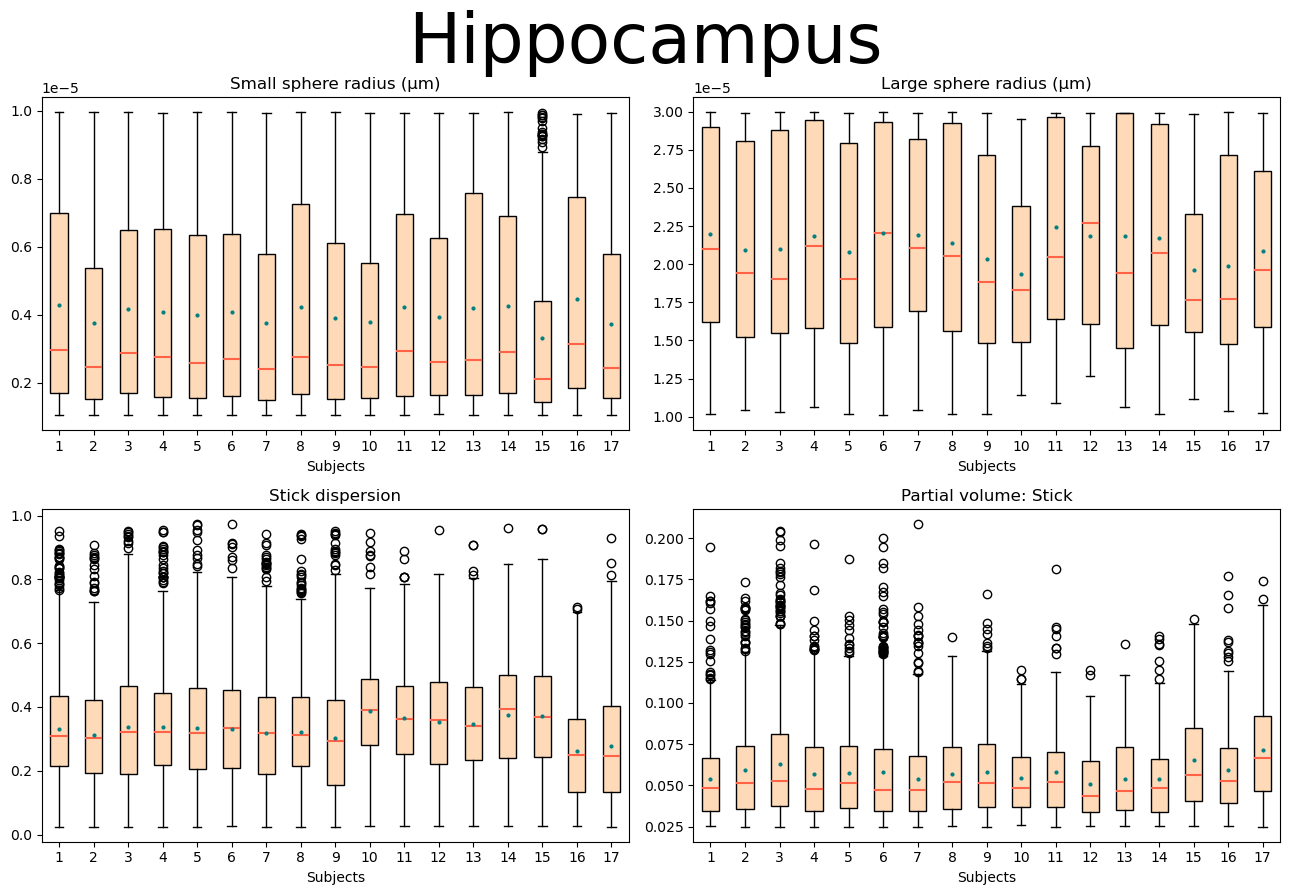

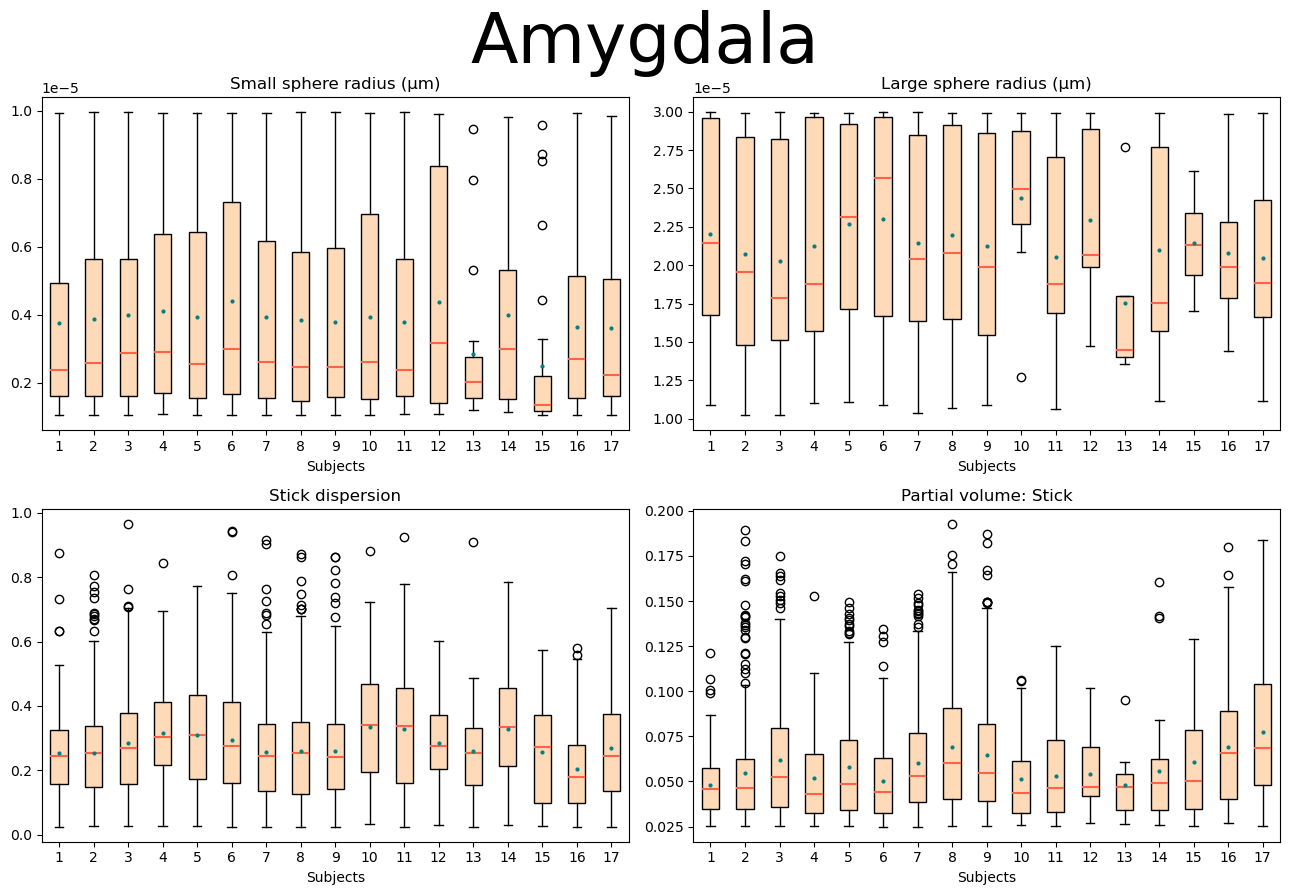

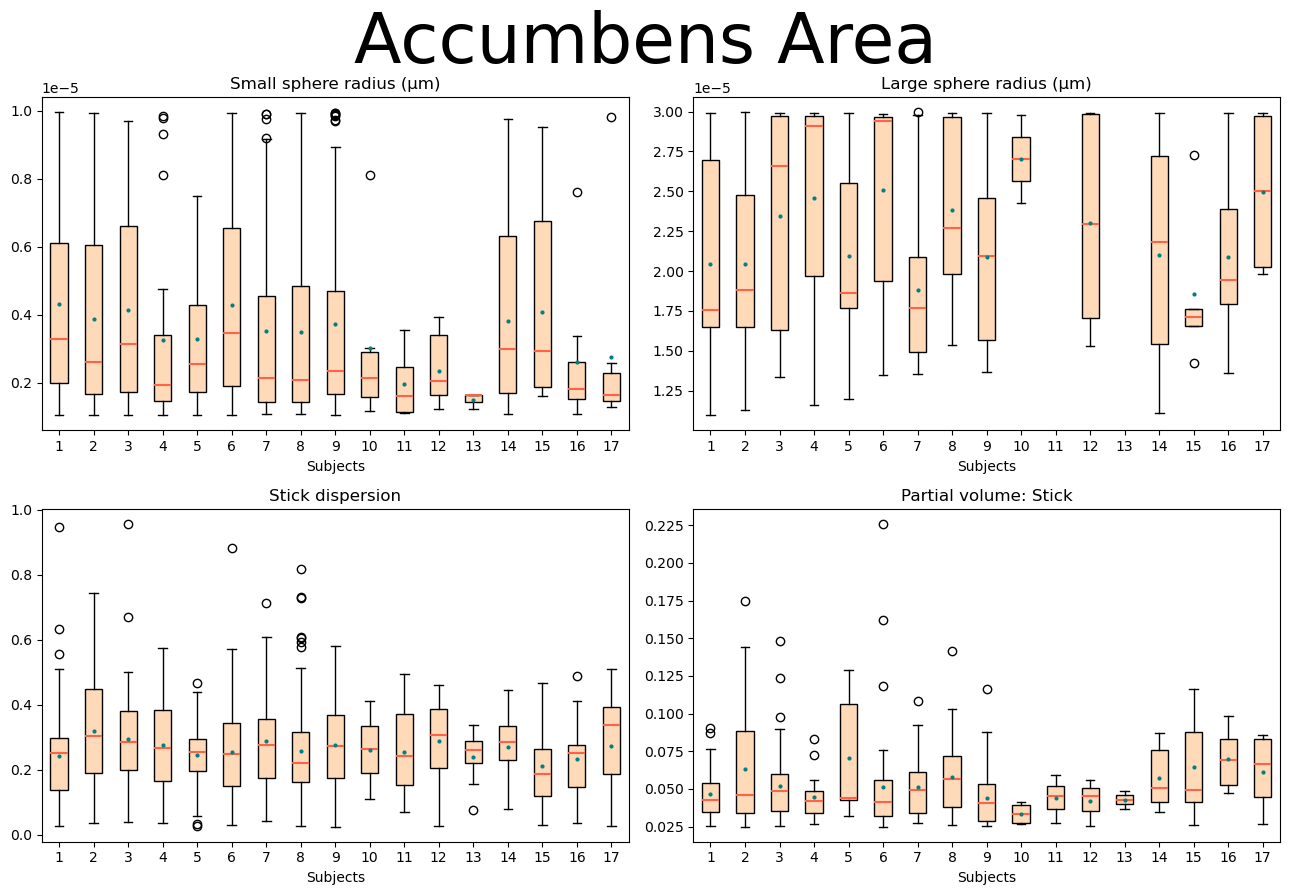

In [ ]:
df = pd.read_json('Fitted_parameters.json', orient='index')

parameter_names = list(df.loc['', 'Thalamus'][0].keys()) # insert row name (ID) in empty string 

plot_indices = [0, 1, 5, 6] # the wanted parameters are in these locations

for column in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(13,10))
    axes = axes.flatten()
    fig.suptitle(column, x=0.5, y=0.92, fontsize=50) 

    for i, param in enumerate(parameter_names):
        if i not in plot_indices:
            continue
        subject_distributions = []

        if i == 0:
            for row in df.index:
                values = df.loc[row, column][0][param]
                values = [x for x in values if round(x,7) not in [1e-6, 1e-5] ] 
                subject_distributions.append(values)

        elif i == 1:
            for row in df.index:
                values = df.loc[row, column][0][param]
                values = [x for x in values if round(x,7) not in [1e-5, 3e-5]] 
                subject_distributions.append(values) 

        elif i == 5:
            for row in df.index:
                values = df.loc[row, column][0][param]
                values = [x for x in values if 0.025 <= x <= 0.975] 
                subject_distributions.append(values)   


        elif i == 6:
            for row in df.index:
                stick_fraction_in_bundle = df.loc[row, column][0][param]
                partial_volume_bundle = df.loc[row, column][0]['partial_volume_3']   
                partial_volume_stick =  [b*s for b, s in zip(partial_volume_bundle, stick_fraction_in_bundle)]
                values = [x for x in partial_volume_stick if 0.025 <= x <= 0.975]
                subject_distributions.append(values)
     
        subplot_titles = ['Small sphere radius (\u03BCm)', 'Large sphere radius (\u03BCm)', 'Stick dispersion', 'Partial volume: Stick'] 
        plot_index = plot_indices.index(i)
        box = axes[plot_index].boxplot(subject_distributions, patch_artist=True, showmeans=True,
                                       meanprops=dict(marker='o', markerfacecolor='teal', markeredgecolor='teal', markersize=2),
                                       medianprops=dict(color='tomato', linewidth=1.5))
        for patch in box['boxes']:
            patch.set_facecolor('peachpuff') 
        axes[plot_index].set_title (subplot_titles[plot_index])
        axes[plot_index].set_xlabel('Subjects')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95] )
    plt.savefig('Figures/Boxplots/boxplot_'+column+'.png')
    plt.show()